In [ ]:
# https://stackoverflow.com/questions/48641189/fitting-3d-data-as-input-into-keras-sequential-model-layer

In [ ]:
# !conda install keras=2.3.1 -y

In [ ]:
# To check avialable CPU and GPU
#import tensorflow as tf
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [1]:
 #Use only CPU
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve,auc

#keras
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# CuDNNLSTM error; The error was because from TensorFlow 2 you do not need to specify CuDNNLSTM. 
# You can just use LSTM with no activation function and it will automatically use the CuDNN version. You do have to install CuDNN first.

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import scikitplot as skplt
import pickle5 as pickle
from utils import *

In [2]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

def create_roc_curve(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)  

    plt.title('Receiver Operating Characteristic' )
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)

    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.show()

# plot no skill and model precision-recall curves
def plot_pr_curve(test_y, model_probs):
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    auc_score = auc(recall, precision)
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(test_y[test_y==1]) / len(test_y)
    pyplot.title('2-class Precision-Recall curve')
    # plot the no skill precision-recall curve
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot model precis|ion-recall curve
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    pyplot.plot(recall, precision, marker='.', label='Model AUC = %0.2f'% auc_score)
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

def plot_history(history):
  # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

In [2]:
# small old ../datasets/AMPsNonAMPs_df.239.plk
# /home/ubuntu/data/AMPsNonAMPs_df.plk old dataset
# /mnt/vdb/thesis/jax/AMPNonAMP.final.reps new dataset
with open( "/mnt/vdb/thesis/jax/AMPNonAMP.V5_C08_sim60.reps", 'rb') as file:
    AMPs_df = pickle.load(file)

In [2]:
# For PWS
with open( '/mnt/vdb/thesis/pwm/AMPnonAMP.sim60_c08.pssm.pkl', 'rb') as file:
    AMPs_df = pickle.load(file)


In [4]:
#AMPs_df.drop_duplicates(subset=['Sequence'],inplace=True)
AMPs_df =AMPs_df[AMPs_df["length"] <=30 ]
AMPs_df 

,ID,length,class,reps
1111,"10015_dbaasp,10016_dbaasp|dbaasp_peptides",11,0,"[0.20464208722114563, -0.055944692343473434, 0..."
973,10026_dbaasp|dbaasp_peptides,22,0,"[0.1005186140537262, 0.0014500601682811975, 0...."
524,10029_dbaasp|dbaasp_peptides,14,0,"[0.14606480300426483, 0.04153195396065712, 0.0..."
1979,"1003,1011,1019,1027,1035|CancerPPD_l_natural",20,0,"[0.02989775501191616, -0.004465686157345772, -..."
1917,10030_dbaasp|dbaasp_peptides,18,0,"[0.11731283366680145, 0.022457238286733627, 0...."
...,...,...,...,...
1609,dbAMP_12148,13,0,"[0.2212764024734497, 0.15402714908123016, 0.12..."
617,dbAMP_12158,17,0,"[0.07279127091169357, 0.05830632895231247, -0...."
1051,dbAMP_12161,16,0,"[0.17415067553520203, 0.11548949033021927, 0.0..."
1821,dbAMP_12203,15,0,"[0.03923531994223595, -0.0253727026283741, -0...."


# Split Train/ Test / Validation set

In [3]:
AMPs_df.shape

(137389, 400)

In [12]:
# For PWM 2D
window_sizes = 20
X = AMPs_df[:,0:window_sizes*20].reshape(len(AMPs_df),1,20,window_sizes)
Y = np.array([0] * 68869 + [1] * 68520)
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [4]:
# For 400 dimension
Y1 =np.array([0] * 68869 + [1] * 68520)
X_train, X_test, y_train, y_test = train_test_split(AMPs_df, Y1, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [3]:
# For jax unirep 
#X= np.array(AMPs_df['reps'].to_list())
#y= np.array(AMPs_df['class'].to_list())
X_train, X_test, y_train, y_test = train_test_split(np.array(AMPs_df['reps'].to_list()), np.array(AMPs_df['class'].to_list()), test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
#del X
#del y

In [4]:
# Given data size
print('Train size: ', len(X_train))
print('Val size: ', len(X_val))
print('Test size: ', len(X_test))

Train size:  51873
Val size:  17292
Test size:  17292


# Model 4: Deep-AmPEP30 + 

In [ ]:
# 3d dimension
# Batchs, n_timesteps, n_features

# Images 3d dimension
# width , heigth , channel

In [6]:
import numpy as np
# https://stackoverflow.com/questions/52803989/how-to-correct-shape-of-keras-input-into-a-3d-array/52804200
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(82433, 400, 1)
(27478, 400, 1)
(27478, 400, 1)


In [ ]:
# original method 
def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
    # Conv
    conv = Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x_input) 
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(conv) 
    conv = MaxPooling1D(pool_size=2)(conv)
    # Flatten NN
    flat = Flatten()(conv)
    
    layer_3 = Dense(128)(flat)
    dropout_3 = Dropout(0.2)(layer_3)
    layer_4 = Dense(10)(dropout_3)
    dropout_4 = Dropout(0.2)(layer_4)
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l2(0.0001))(dropout_4)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_Modelbaseline()
model.summary()

In [17]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.00001)

In [11]:
checkpoint = ModelCheckpoint("/mnt/vdb/thesis/AmPPEP30.1900.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# Early Stopping
es = EarlyStopping(monitor='loss', patience=8, verbose=1)

#learning rate decay
lr_scheduler = LearningRateScheduler(lr_schedule)

history = model.fit(X_train, y_train, epochs=100,
                    batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[checkpoint, es,lr_scheduler], verbose=1)

 Learning rate:  0.01
Epoch 1/100
832/832 [==============================] - ETA: 0s - loss: 3.6077 - accuracy: 0.6687
Epoch 00001: loss improved from inf to 3.60769, saving model to /mnt/vdb/thesis/AmPPEP30.1900.hdf5
832/832 [==============================] - 225s 270ms/step - loss: 3.6077 - accuracy: 0.6687 - val_loss: 0.7354 - val_accuracy: 0.5756
 Learning rate:  0.01
Epoch 2/100
832/832 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.7826
Epoch 00002: loss improved from 3.60769 to 0.47920, saving model to /mnt/vdb/thesis/AmPPEP30.1900.hdf5
832/832 [==============================] - 222s 267ms/step - loss: 0.4792 - accuracy: 0.7826 - val_loss: 0.4271 - val_accuracy: 0.8109
 Learning rate:  0.01
Epoch 3/100
832/832 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8138
Epoch 00003: loss improved from 0.47920 to 0.42904, saving model to /mnt/vdb/thesis/AmPPEP30.1900.hdf5
832/832 [==============================] - 220s 264ms/step - loss: 0

In [17]:
display_model_score(model,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

1663/1663 [==============================] - 63s 38ms/step - loss: 0.2671 - accuracy: 0.8893
Train loss:  0.26714572310447693
Train accuracy:  0.8892960548400879
----------------------------------------------------------------------
555/555 [==============================] - 21s 38ms/step - loss: 0.3079 - accuracy: 0.8721
Val loss:  0.307868629693985
Val accuracy:  0.8721461296081543
----------------------------------------------------------------------
555/555 [==============================] - 21s 38ms/step - loss: 0.3020 - accuracy: 0.8752
Test loss:  0.3020343482494354
Test accuracy:  0.8752466440200806


In [18]:
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      8928
           1       0.87      0.88      0.87      8811

    accuracy                           0.88     17739
   macro avg       0.88      0.88      0.88     17739
weighted avg       0.88      0.88      0.88     17739



# Model 3: ProtCNN
https://www.biorxiv.org/content/10.1101/626507v3.full

In [5]:
# convert format 
import numpy as np
# https://stackoverflow.com/questions/52803989/how-to-correct-shape-of-keras-input-into-a-3d-array/52804200
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(51873, 400, 1)
(17292, 400, 1)
(17292, 400, 1)


In [5]:
def residual_block(data, filters, d_rate):
  """
  residual_block consist of two resnet layers
  For dilation_rate  # https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d
  
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

In [31]:
x_input = Input(shape=(1900,1))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(1000, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)
#x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)

model_ProtCNN = Model(inputs=x_input, outputs=x_output)
model_ProtCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_ProtCNN.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1900, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_38 (Conv1D)              (None, 1900, 128)    256         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 1900, 128)    512         conv1d_38[0][0]                  
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 1900, 128)    0           batch_normalization_30[0][0]     
______________________________________________________________________________________

In [ ]:
# good model for detect nonAMP

x_input = Input(shape=(1900,1))

#initial conv
conv = Conv1D(256, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 256, 2)
res2 = residual_block(res1, 256, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
layer_4 = Dense(1211 , activation='relu')(x)
layer_4 = Dropout(0.5)(layer_4)
layer_4 = Dense(1211 , activation='relu')(layer_4)
layer_4 = Dropout(0.5)(layer_4)
layer_4 = Dense(1211 , activation='relu')(layer_4)
layer_4 = Dropout(0.5)(layer_4)
layer_4 = Dense(1211 , activation='relu')(layer_4)
x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(layer_4)

model_ProtCNN = Model(inputs=x_input, outputs=x_output)
model_ProtCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_ProtCNN.summary()

In [6]:
# model

x_input = Input(shape=(1900,1))

#initial conv
conv = Conv1D(256, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 256, 2)
res2 = residual_block(res1, 256, 3)

x = MaxPooling1D(3)(res2)
x = BatchNormalization()(x)

# softmax classifier
x = Flatten()(x)
layer_4 = Dense(1211 , activation='relu')(x)
layer_4 = Dropout(0.5)(layer_4)
layer_4 = Dense(512 , activation='relu')(layer_4)
layer_4 = Dropout(0.5)(layer_4)
x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(layer_4)

model_ProtCNN = Model(inputs=x_input, outputs=x_output)
model_ProtCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_ProtCNN.summary()

NameError: name 'residual_block' is not defined

In [7]:
#from keras import backend as K
#K.set_value(model_ProtCNN.optimizer.learning_rate, 0.00001)
def lr_schedule(epoch):
    
    lr = 1e-3
    if epoch > 80:
        lr = 0.1e-6
    elif epoch > 50:    
        lr = 0.3e-5
    elif epoch > 20:
        lr = 1e-4
        
    print(' Learning rate: ', lr)    
    return lr 

In [10]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
# val_loss
# ProtCNN_256X2_NN1221X4.V2.h5
checkpoint = ModelCheckpoint("/mnt/vdb/thesis/ProtCNN.V5.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# val_accuracy

lr_scheduler = LearningRateScheduler(lr_schedule)

history2 = model_ProtCNN.fit(
    X_train, y_train,
    epochs=100, batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, es,lr_scheduler]
    )


 Learning rate:  0.001
Epoch 1/100
644/645 [============================>.] - ETA: 0s - loss: 2.7184 - accuracy: 0.6246
Epoch 00001: loss improved from inf to 2.71835, saving model to /mnt/vdb/thesis/ProtCNN.V5.h5
645/645 [==============================] - 127s 196ms/step - loss: 2.7184 - accuracy: 0.6245 - val_loss: 1.3044 - val_accuracy: 0.7311
 Learning rate:  0.001
Epoch 2/100
644/645 [============================>.] - ETA: 0s - loss: 1.1884 - accuracy: 0.6522
Epoch 00002: loss improved from 2.71835 to 1.18844, saving model to /mnt/vdb/thesis/ProtCNN.V5.h5
645/645 [==============================] - 129s 200ms/step - loss: 1.1884 - accuracy: 0.6522 - val_loss: 0.8606 - val_accuracy: 0.8189
 Learning rate:  0.001
Epoch 3/100
644/645 [============================>.] - ETA: 0s - loss: 0.8685 - accuracy: 0.6792
Epoch 00003: loss improved from 1.18844 to 0.86846, saving model to /mnt/vdb/thesis/ProtCNN.V5.h5
645/645 [==============================] - 129s 200ms/step - loss: 0.8685 - accu

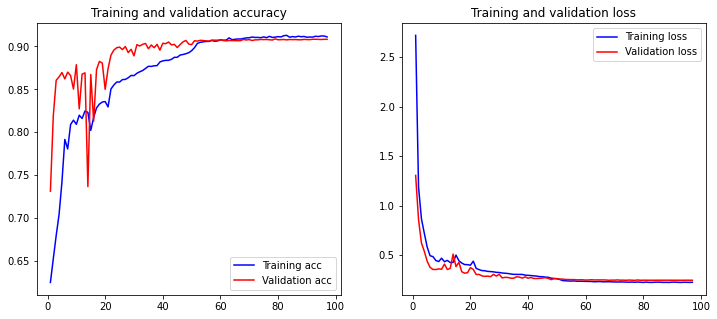

In [11]:
plot_history(history2)

In [13]:
model_ProtCNN.save("/mnt/vdb/thesis/ProtCNN.V5.h5")
#model_ProtCNN= keras.models.load_model("/mnt/vdb/ProtCNN.hdf5")

In [12]:
y_probas = model_ProtCNN.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     13856
           1       0.92      0.88      0.90     13622

    accuracy                           0.90     27478
   macro avg       0.91      0.90      0.90     27478
weighted avg       0.91      0.90      0.90     27478



In [19]:
y_probas = model_ProtCNN.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     25564
           1       0.94      0.95      0.95     25244

    accuracy                           0.95     50808
   macro avg       0.95      0.95      0.95     50808
weighted avg       0.95      0.95      0.95     50808



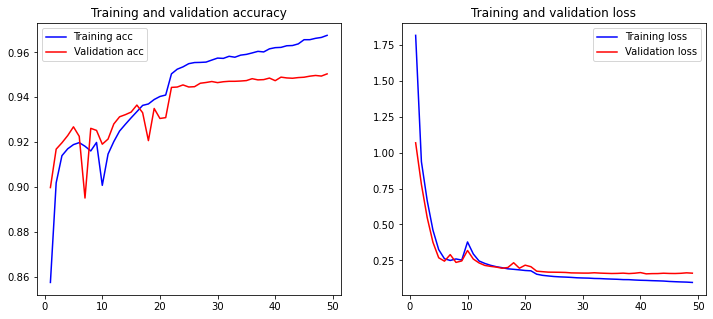

In [20]:
plot_history(history2)

In [3]:
display_model_score(model_ProtCNN,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

NameError: name 'model_ProtCNN' is not defined

# with PWM

In [ ]:
# 2D


In [9]:
x_input = Input(shape=(400,1))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
layer_4 = Dense(1211 , activation='relu')(x)
layer_4 = Dropout(0.5)(layer_4)
layer_4 = Dense(256 , activation='relu')(layer_4)
layer_4 = Dropout(0.5)(layer_4)
x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(layer_4)

model_ProtCNN = Model(inputs=x_input, outputs=x_output)
model_ProtCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_ProtCNN.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 400, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 400, 128)     256         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 128)     512         conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 400, 128)     0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
# val_loss
# ProtCNN_256X2_NN1221X4.V2.h5
checkpoint = ModelCheckpoint("/mnt/vdb/thesis/ProtCNN.V5.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# val_accuracy

lr_scheduler = LearningRateScheduler(lr_schedule)

history2 = model_ProtCNN.fit(
    X_train, y_train,
    epochs=100, batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[ es,lr_scheduler]
    )

 Learning rate:  0.001
Epoch 1/100
406/406 [==============================] - 9s 21ms/step - loss: 0.0438 - accuracy: 0.4995 - val_loss: 2.8720e-07 - val_accuracy: 0.5023
 Learning rate:  0.001
Epoch 2/100
406/406 [==============================] - 8s 20ms/step - loss: 7.0659e-08 - accuracy: 0.4990 - val_loss: 5.9874e-08 - val_accuracy: 0.4977
 Learning rate:  0.001
Epoch 3/100
406/406 [==============================] - 8s 20ms/step - loss: 5.9716e-08 - accuracy: 0.4991 - val_loss: 5.9874e-08 - val_accuracy: 0.4977
 Learning rate:  0.001
Epoch 4/100
406/406 [==============================] - 8s 20ms/step - loss: 5.9716e-08 - accuracy: 0.4991 - val_loss: 5.9874e-08 - val_accuracy: 0.4977
 Learning rate:  0.001
Epoch 5/100
406/406 [==============================] - 8s 20ms/step - loss: 5.9716e-08 - accuracy: 0.4991 - val_loss: 5.9874e-08 - val_accuracy: 0.4977
 Learning rate:  0.001
Epoch 6/100
406/406 [==============================] - 8s 20ms/step - loss: 5.9716e-08 - accuracy: 0.4991 

In [11]:
y_probas = model_ProtCNN.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      8726
           1       0.00      0.00      0.00      8566

    accuracy                           0.50     17292
   macro avg       0.25      0.50      0.34     17292
weighted avg       0.25      0.50      0.34     17292



/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
display_model_score(model_ProtCNN,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

1622/1622 [==============================] - 4s 3ms/step - loss: 5.9716e-08 - accuracy: 0.4991
Train loss:  5.971610761434931e-08
Train accuracy:  0.49906501173973083
----------------------------------------------------------------------
541/541 [==============================] - 1s 3ms/step - loss: 5.9874e-08 - accuracy: 0.4977
Val loss:  5.987351414660225e-08
Val accuracy:  0.497744619846344
----------------------------------------------------------------------
541/541 [==============================] - 1s 3ms/step - loss: 5.9053e-08 - accuracy: 0.5046
Test loss:  5.905313926746203e-08
Test accuracy:  0.5046263933181763


In [ ]:
plot_history(history2)

In [11]:
model_ProtCNN.save("/mnt/vdb/thesis/ProtCNN.V5.set10.h5")

# Training set 2

## SET 9

### JAX

In [3]:
import pickle5 as pickle
with open( "/mnt/vdb/thesis/trainingset2/set9/jax/AMPNonAMP.reps", 'rb') as file:
    AMPNonAMP_df = pickle.load(file)
with open( "/mnt/vdb/thesis/trainingset2/benchmark_set/jax/AMPNonAMP.benchmark_set.reps", 'rb') as file:
    benchmark_AMPs_df = pickle.load(file)
    
X_train = np.array(AMPNonAMP_df['reps'].to_list())
y_train = np.array(AMPNonAMP_df['class'].to_list())
X_test = np.array(benchmark_AMPs_df["reps"].to_list())
y_test = np.array( benchmark_AMPs_df["class"].to_list())

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(56611, 1900, 1)
(3556, 1900, 1)
(14153, 1900, 1)


## PSSM

In [12]:
with open( "/mnt/vdb/thesis/trainingset2/set9/pssm/AMP/AMP.pssm.plk", 'rb') as file:
    AMPs_df = pickle.load(file)
AMPs_df["class"] = 0
with open( "/mnt/vdb/thesis/trainingset2/set9/pssm/nonAMP/nonAMP.pssm.plk", 'rb') as file:
    nonAMPs_df = pickle.load(file)   
nonAMPs_df["class"] = 1

AMPNonAMP_df = pd.concat([AMPs_df, nonAMPs_df], ignore_index=True)

#AMPs_df = AMPs_df[AMPs_df["length"] <= 300 ]
with open( "../datasets/thesis/trainingset2/benchmark_set/AMPnonAMP.pssm.pkl", 'rb') as file:
    benchmark_AMPs_df = pickle.load(file)
    
X_train = np.array(AMPNonAMP_df['reps'].to_list())
y_train = np.array(AMPNonAMP_df['class'].to_list())
X_test = np.array(benchmark_AMPs_df["reps"].to_list())
y_test = np.array( benchmark_AMPs_df["class"].to_list())
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(56620, 400, 1)
(3556, 400, 1)
(14155, 400, 1)


In [4]:
def create_Modelbaseline_pssm():
    x_input = Input(shape=(400,1))
    #initial conv
    conv = Conv1D(256, 1, padding='same')(x_input) 

    # per-residue representation
    res1 = residual_block(conv, 256, 2)
    res2 = residual_block(res1, 256, 3)

    x = MaxPooling1D(3)(res2)
    #x = Dropout(0.5)(x)

    # softmax classifier
    x = Flatten()(x)
    layer_4 = Dense(1211 , activation='relu')(x)
    layer_4 = BatchNormalization()(layer_4)
    layer_4 = Dense(1211 , activation='relu')(layer_4)
    layer_4 = BatchNormalization()(layer_4) # layer_4 = Dropout(0.5)(layer_4)
    layer_4 = Dense(1211 , activation='relu')(layer_4)
    layer_4 = BatchNormalization()(layer_4)
    layer_4 = Dense(1211 , activation='relu')(layer_4)
    layer_4 = BatchNormalization()(layer_4) # layer_4 = Dropout(0.5)(layer_4)
    x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(layer_4)

    model_ProtCNN = Model(inputs=x_input, outputs=x_output)
    model_ProtCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model_ProtCNN


def create_Modelbaseline_jax():
    x_input = Input(shape=(1900,1))

    #initial conv
    conv = Conv1D(256, 1, padding='same')(x_input) 

    # per-residue representation
    res1 = residual_block(conv, 256, 2)
    res2 = residual_block(res1, 256, 3)

    x = MaxPooling1D(3)(res2)
    #x = Dropout(0.5)(x)

    # softmax classifier
    x = Flatten()(x)
    layer_4 = Dense(1211 , activation='relu')(x)
    layer_4 = BatchNormalization()(layer_4)
    layer_4 = Dense(1211 , activation='relu')(layer_4)
    layer_4 = BatchNormalization()(layer_4) # layer_4 = Dropout(0.5)(layer_4)
    layer_4 = Dense(1211 , activation='relu')(layer_4)
    layer_4 = BatchNormalization()(layer_4)
    layer_4 = Dense(1211 , activation='relu')(layer_4)
    layer_4 = BatchNormalization()(layer_4) # layer_4 = Dropout(0.5)(layer_4)
    x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(layer_4)

    model_ProtCNN = Model(inputs=x_input, outputs=x_output)
    model_ProtCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model_ProtCNN

In [87]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
# val_loss
# ProtCNN_256X2_NN1221X4.V2.h5
checkpoint = ModelCheckpoint("/mnt/vdb/thesis/ProtCNN.set9.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# val_accuracy

lr_scheduler = LearningRateScheduler(lr_schedule)

history2 = model_ProtCNN.fit(
    X_train, y_train,
    epochs=100, batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[ es,lr_scheduler]
    )


 Learning rate:  0.001
Epoch 1/100
443/443 [==============================] - 20s 44ms/step - loss: 0.8652 - accuracy: 0.8448 - val_loss: 0.8478 - val_accuracy: 0.5005
 Learning rate:  0.001
Epoch 2/100
443/443 [==============================] - 19s 43ms/step - loss: 0.3985 - accuracy: 0.8599 - val_loss: 0.4798 - val_accuracy: 0.7859
 Learning rate:  0.001
Epoch 3/100
443/443 [==============================] - 19s 43ms/step - loss: 0.3378 - accuracy: 0.8668 - val_loss: 0.6041 - val_accuracy: 0.7225
 Learning rate:  0.001
Epoch 4/100
443/443 [==============================] - 19s 43ms/step - loss: 0.3369 - accuracy: 0.8655 - val_loss: 0.4981 - val_accuracy: 0.7612
 Learning rate:  0.001
Epoch 5/100
443/443 [==============================] - 19s 43ms/step - loss: 0.3409 - accuracy: 0.8688 - val_loss: 7.3398 - val_accuracy: 0.5039
 Learning rate:  0.001
Epoch 6/100
443/443 [==============================] - 19s 43ms/step - loss: 0.3302 - accuracy: 0.8700 - val_loss: 11.2983 - val_accuracy

## PSSM

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1778
           1       0.87      0.77      0.82      1778

    accuracy                           0.83      3556
   macro avg       0.83      0.83      0.83      3556
weighted avg       0.83      0.83      0.83      3556



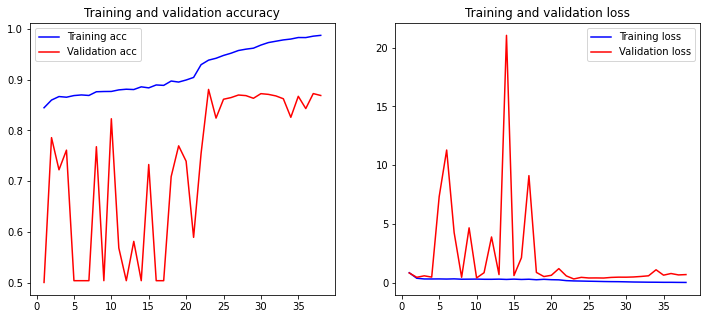

In [97]:
y_probas = model_ProtCNN.predict(X_test)

threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))
plot_history(history2)


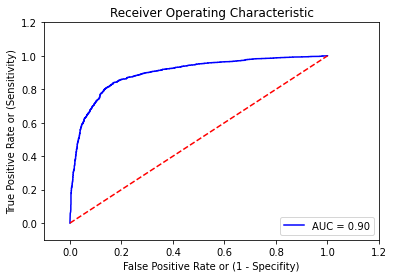

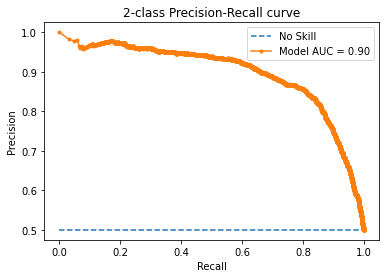

In [92]:
create_roc_curve(y_test,y_probas)
# plot precision-recall curves
plot_pr_curve(y_test, y_probas)

In [99]:
y_probas

array([[7.6426226e-01],
       [2.4973087e-05],
       [3.7965246e-02],
       ...,
       [9.9999952e-01],
       [9.5996290e-01],
       [1.0000000e+00]], dtype=float32)

In [103]:
#skplt.metrics.plot_roc(y_test, y_probas)
skplt.metrics.plot_precision_recall_curve(y_test, y_predict)


/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


inputs = np.concatenate((X_train, X_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
_precision = []
_recal = []
_f1 = []
_auc_pr = []
_roc_pr = []
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index  in kfold.split(inputs, targets):
    
    X_train= inputs[train_index]
    y_train= targets[train_index]
    X_val=  inputs[test_index]
    y_val = targets[test_index]
    # Early Stopping
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

    #learning rate decay
    lr_scheduler = LearningRateScheduler(lr_schedule)
    model = create_Modelbaseline_pssm()
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X_train, y_train, epochs=100,batch_size=128,
                        validation_data=(X_val, y_val),
                        callbacks=[es, lr_scheduler], verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    # predict probabilities for test set
    y_probas = model.predict(X_test)
    threshold = 0.5
    y_predict = np.where(y_probas > threshold, 1, 0)

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_predict, y_test)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = (precision_score(y_predict,y_test, pos_label= 1)+precision_score(y_predict,y_test , pos_label= 0))*0.5
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = (recall_score(y_predict,y_test, pos_label= 1)+recall_score(y_predict,y_test , pos_label= 0))*0.5
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 =  (f1_score(y_predict,y_test, pos_label= 1)+f1_score(y_predict,y_test , pos_label= 0))*0.5
    print('F1 score: %f' % f1)
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])  
    _precision.append(precision * 100)  
    _recal.append(recall * 100)  
    _f1.append(f1 * 100)  
 
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Pecision: {np.mean(_precision)} (+- {np.std(_precision)})')
print(f'> Recall: {np.mean(_recal)} (+- {np.std(_recal)})')
print(f'> F1: {np.mean(_f1)} (+- {np.std(_f1)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

## JAX -result

              precision    recall  f1-score   support

           0       0.76      0.95      0.85      1778
           1       0.93      0.71      0.80      1778

    accuracy                           0.83      3556
   macro avg       0.85      0.83      0.82      3556
weighted avg       0.85      0.83      0.82      3556



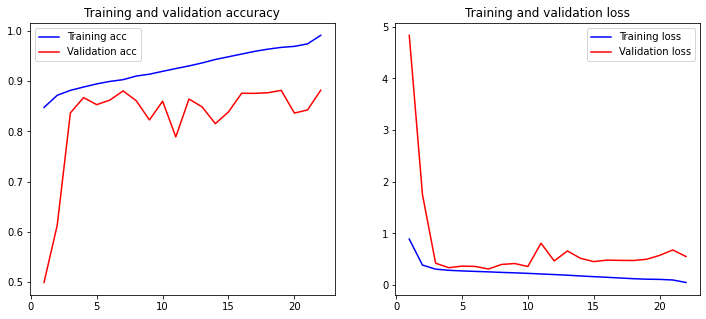

In [15]:
y_probas = model_ProtCNN.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))
plot_history(history2)

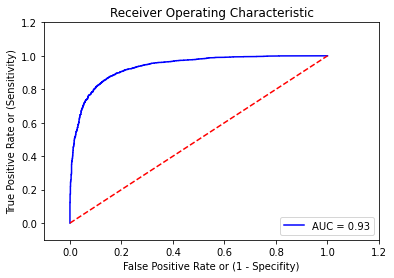

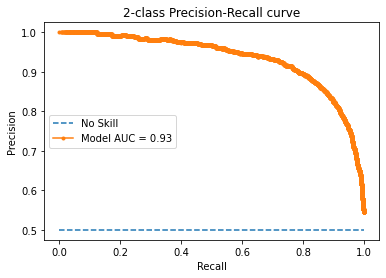

In [82]:
create_roc_curve(y_test,y_probas)
# plot precision-recall curves
plot_pr_curve(y_test, y_probas)

              precision    recall  f1-score   support

           0       0.76      0.96      0.84      1778
           1       0.94      0.69      0.80      1778

    accuracy                           0.82      3556
   macro avg       0.85      0.82      0.82      3556
weighted avg       0.85      0.82      0.82      3556



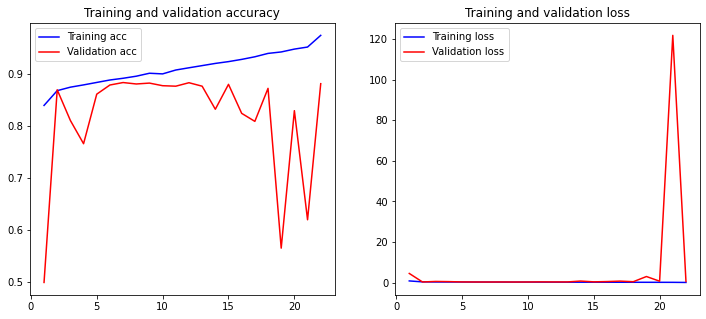

In [12]:
y_probas = model_ProtCNN.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))
plot_history(history2)

              precision    recall  f1-score   support

           0       0.72      0.94      0.81      1778
           1       0.91      0.63      0.74      1778

    accuracy                           0.78      3556
   macro avg       0.81      0.78      0.78      3556
weighted avg       0.81      0.78      0.78      3556



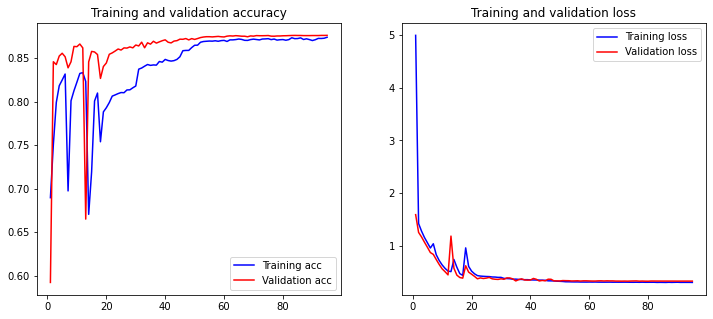

In [16]:
y_probas = model_ProtCNN.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))
plot_history(history2)

In [91]:
model_ProtCNN.save("/mnt/vdb/thesis/ProtCNN.set9.pssm.h5")

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


inputs = np.concatenate((X_train, X_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
_precision = []
_recal = []
_f1 = []
_auc_pr = []
_roc_pr = []
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index  in kfold.split(inputs, targets):
    
    X_train= inputs[train_index]
    y_train= targets[train_index]
    X_val=  inputs[test_index]
    y_val = targets[test_index]
    # Early Stopping
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

    #learning rate decay
    lr_scheduler = LearningRateScheduler(lr_schedule)
    model = create_Modelbaseline_pssm()
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X_train, y_train, epochs=100,batch_size=128,
                        validation_data=(X_val, y_val),
                        callbacks=[es, lr_scheduler], verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    # predict probabilities for test set
    y_probas = model.predict(X_test)
    threshold = 0.5
    y_predict = np.where(y_probas > threshold, 1, 0)

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_predict, y_test)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = (precision_score(y_predict,y_test, pos_label= 1)+precision_score(y_predict,y_test , pos_label= 0))*0.5
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = (recall_score(y_predict,y_test, pos_label= 1)+recall_score(y_predict,y_test , pos_label= 0))*0.5
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 =  (f1_score(y_predict,y_test, pos_label= 1)+f1_score(y_predict,y_test , pos_label= 0))*0.5
    print('F1 score: %f' % f1)
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])  
    _precision.append(precision * 100)  
    _recal.append(recall * 100)  
    _f1.append(f1 * 100)  
 
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Pecision: {np.mean(_precision)} (+- {np.std(_precision)})')
print(f'> Recall: {np.mean(_recal)} (+- {np.std(_recal)})')
print(f'> F1: {np.mean(_f1)} (+- {np.std(_f1)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
Epoch 00037: early stopping
Score fo

## SET 10 

In [3]:
import pickle5 as pickle
with open( "/mnt/vdb/thesis/trainingset2/set10/jax/AMPNonAMP.reps", 'rb') as file:
    AMPNonAMP_df = pickle.load(file)
with open( "/mnt/vdb/thesis/trainingset2/benchmark_set/jax/AMPNonAMP.benchmark_set.reps", 'rb') as file:
    benchmark_AMPs_df = pickle.load(file)
    
X_train = np.array(AMPNonAMP_df['reps'].to_list())
y_train = np.array(AMPNonAMP_df['class'].to_list())
X_test = np.array(benchmark_AMPs_df["reps"].to_list())
y_test = np.array( benchmark_AMPs_df["class"].to_list())

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)


(35470, 1900, 1)
(3556, 1900, 1)
(8868, 1900, 1)


In [7]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
# val_loss
# ProtCNN_256X2_NN1221X4.V2.h5
checkpoint = ModelCheckpoint("/mnt/vdb/thesis/ProtCNN.set10.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# val_accuracy

lr_scheduler = LearningRateScheduler(lr_schedule)
model_ProtCNN = create_Modelbaseline_jax()
history2 = model_ProtCNN.fit(
    X_train, y_train,
    epochs=100, batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[ es,lr_scheduler]
    )


 Learning rate:  0.001
Epoch 1/100
278/278 [==============================] - 50s 181ms/step - loss: 1.0846 - accuracy: 0.8448 - val_loss: 8.8734 - val_accuracy: 0.5029
 Learning rate:  0.001
Epoch 2/100
278/278 [==============================] - 50s 180ms/step - loss: 0.5510 - accuracy: 0.8633 - val_loss: 0.8941 - val_accuracy: 0.6063
 Learning rate:  0.001
Epoch 3/100
278/278 [==============================] - 50s 179ms/step - loss: 0.3851 - accuracy: 0.8676 - val_loss: 0.3852 - val_accuracy: 0.8490
 Learning rate:  0.001
Epoch 4/100
278/278 [==============================] - 50s 180ms/step - loss: 0.3227 - accuracy: 0.8755 - val_loss: 0.3452 - val_accuracy: 0.8570
 Learning rate:  0.001
Epoch 5/100
278/278 [==============================] - 50s 180ms/step - loss: 0.2964 - accuracy: 0.8815 - val_loss: 0.4689 - val_accuracy: 0.8373
 Learning rate:  0.001
Epoch 6/100
278/278 [==============================] - 50s 179ms/step - loss: 0.2842 - accuracy: 0.8873 - val_loss: 0.3849 - val_acc

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1778
           1       0.81      0.75      0.78      1778

    accuracy                           0.78      3556
   macro avg       0.79      0.78      0.78      3556
weighted avg       0.79      0.78      0.78      3556



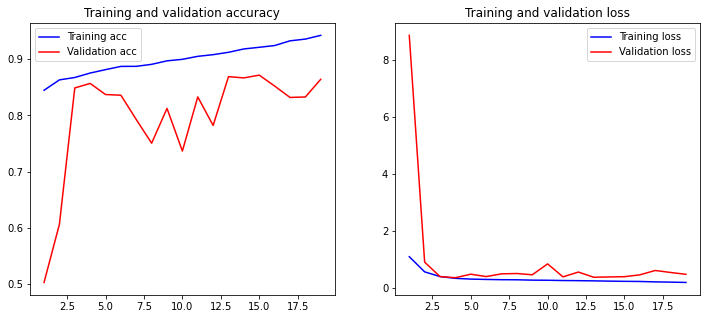

In [8]:
y_probas = model_ProtCNN.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))
plot_history(history2)

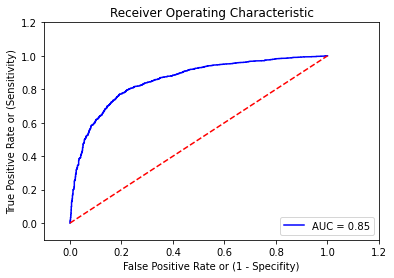

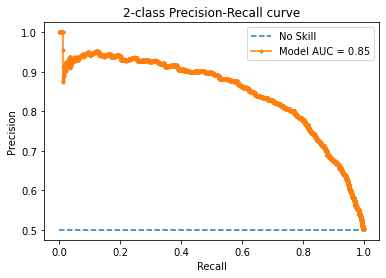

In [9]:
create_roc_curve(y_test,y_probas)
# plot precision-recall curves
plot_pr_curve(y_test, y_probas)

In [12]:
from tensorflow import keras
model = keras.models.load_model('/mnt/vdb/thesis/ProtCNN.set9.h5')

# Lower Threashod
with open( "/mnt/vdb/thesis/trainingset2/benchmark_set/jax/AMPNonAMP.benchmark_set.reps", 'rb') as file:
    benchmark_AMPs_df = pickle.load(file)
    
X_test = np.array(benchmark_AMPs_df["reps"].to_list())
y_test = np.array( benchmark_AMPs_df["class"].to_list())    



In [4]:
from tensorflow import keras
model = keras.models.load_model('/mnt/vdb/thesis/ProtCNN.set9.pssm.h5')

with open( "../datasets/thesis/trainingset2/benchmark_set/AMPnonAMP.pssm.pkl", 'rb') as file:
    benchmark_AMPs_df = pickle.load(file)

X_test = np.array(benchmark_AMPs_df["reps"].to_list())
y_test = np.array( benchmark_AMPs_df["class"].to_list())    

In [5]:
# -set9 -PSSM
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1778
           1       0.87      0.77      0.82      1778

    accuracy                           0.83      3556
   macro avg       0.83      0.83      0.83      3556
weighted avg       0.83      0.83      0.83      3556



In [16]:
threshold = 0.19
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1778
           1       0.84      0.83      0.83      1778

    accuracy                           0.83      3556
   macro avg       0.83      0.83      0.83      3556
weighted avg       0.83      0.83      0.83      3556



In [7]:
# - set 10
from tensorflow import keras
model = keras.models.load_model('/mnt/vdb/thesis/ProtCNN.V5.set10.h5')

# Lower Threashod
with open( "/mnt/vdb/thesis/trainingset2/benchmark_set/jax/AMPNonAMP.benchmark_set.reps", 'rb') as file:
    benchmark_AMPs_df = pickle.load(file)
    
X_test = np.array(benchmark_AMPs_df["reps"].to_list())
y_test = np.array( benchmark_AMPs_df["class"].to_list())    


In [38]:
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1778
           1       0.81      0.75      0.78      1778

    accuracy                           0.78      3556
   macro avg       0.79      0.78      0.78      3556
weighted avg       0.79      0.78      0.78      3556



In [39]:
threshold = 0.4
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      1778
           1       0.78      0.79      0.79      1778

    accuracy                           0.79      3556
   macro avg       0.79      0.79      0.79      3556
weighted avg       0.79      0.79      0.79      3556



              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1778
           1       0.79      0.78      0.78      1778

    accuracy                           0.79      3556
   macro avg       0.79      0.79      0.79      3556
weighted avg       0.79      0.79      0.79      3556



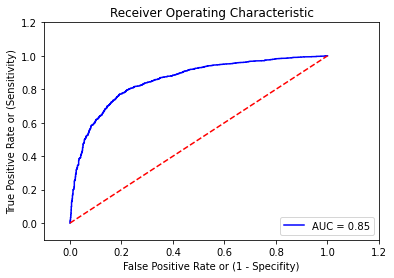

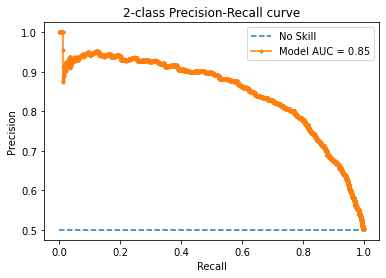

In [57]:
threshold = 0.43
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))
create_roc_curve(y_test,y_probas)
# plot precision-recall curves
plot_pr_curve(y_test, y_probas)

# Benchhmark 920

In [3]:
from tensorflow import keras
model = keras.models.load_model('/mnt/vdb/thesis/ProtCNN.V5.set10.h5')

# Lower Threashod
with open( "/mnt/vdb/thesis/trainingset2/benchmark_set_920/jax/AMPNonAMP.benchmark_set.reps", 'rb') as file:
    benchmark_AMPs_df = pickle.load(file)
    
X_test = np.array(benchmark_AMPs_df["reps"].to_list())
y_test = np.array( benchmark_AMPs_df["class"].to_list())    


              precision    recall  f1-score   support

           0       0.66      0.85      0.74       920
           1       0.78      0.56      0.65       920

    accuracy                           0.70      1840
   macro avg       0.72      0.70      0.70      1840
weighted avg       0.72      0.70      0.70      1840



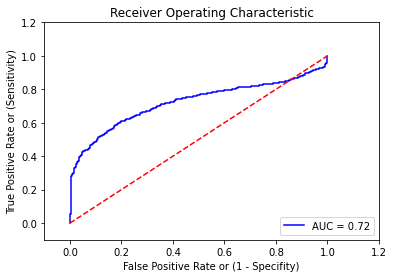

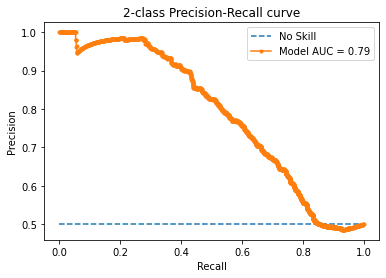

In [5]:
threshold = 0.43
y_probas = model.predict(X_test)
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))
create_roc_curve(y_test,y_probas)
# plot precision-recall curves
plot_pr_curve(y_test, y_probas)

# Benchmark 721

In [6]:
from Bio import SeqIO
amp_fasta= "../datasets/thesis/trainingset2/benchmark_set/721/test.only.fa"
with open(amp_fasta) as fasta_file:  # Will close handle cleanly
    identifiers = []
    lengths = []
    sequence = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        sequence.append(str(seq_record.seq))
        lengths.append(len(seq_record.seq))

test_df = pd.DataFrame(list(zip(identifiers, sequence, lengths)), columns =['ID', 'Sequence', 'length']) 
test_df # 127018

,ID,Sequence,length
0,AP01235,FNKLKQGSSKRTCAKCFRKIMPSVHELDERRRGANRWAAGFRKCVS...,51
1,AP02387,RLGTALPALLKTLLAGLNG,19
2,AP02150,YEALVTSILGKLTGLWHNDSVDFMGHICYFRRRPKIRRFKLYHEGK...,65
3,AP00314,VFCTCRGFLCGSGERASGSCTINGVRHTLCCRR,33
4,AP01183,ATYYGNGLYCNKEKCWVDWNQAKGEIGKIIVNGWVNHGPWAPRR,44
...,...,...,...
1419,UniRef50_Q2FLE8,PYYWINGPLVTDAPEGTDVHAIHKGNISI,29
1420,UniRef50_A8QA64,WLGERWVVQTVLP,13
1421,UniRef50_Q9V4S8,PGTSGGLGQSELR,13
1422,UniRef50_Q8EFB4,ELIQGLTQPVLGVCLGMQMLTLLSKERGGQALDCQAHDCKCLGIIP...,79


              precision    recall  f1-score   support

           0       0.79      0.81      0.80       712
           1       0.80      0.79      0.80       712

    accuracy                           0.80      1424
   macro avg       0.80      0.80      0.80      1424
weighted avg       0.80      0.80      0.80      1424



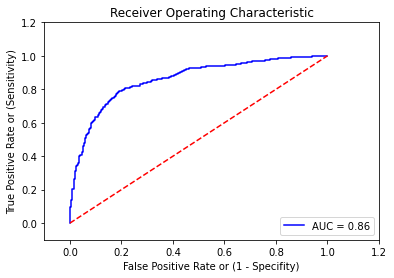

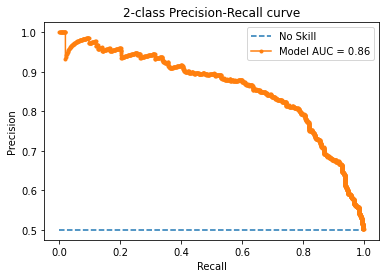

In [19]:
benchmark_AMPs_df = benchmark_AMPs_df[benchmark_AMPs_df.ID.isin(test_df["ID"].to_list())]
X_test = np.array(benchmark_AMPs_df["reps"].to_list())
y_test = np.array( benchmark_AMPs_df["class"].to_list())
threshold = 0.44
y_probas = model.predict(X_test)
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))
create_roc_curve(y_test,y_probas)
# plot precision-recall curves
plot_pr_curve(y_test, y_probas)